In [7]:
import os
import requests
import re
import sys
import regex as re

In [8]:
import pandas as pd
import numpy as np
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Imports the Google Cloud client library
from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [10]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [11]:
%pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True)

Note: you may need to restart the kernel to use updated packages.
Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [12]:
%%time
df_filt_2020=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data5_2021_Topics_Sentiments_NER.csv',lineterminator='\n')
df_filt_2021=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data6_2021v2_Topics_Sentiments_NER.csv',lineterminator='\n')
df_filt_2022=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data6_2022_Topics_Sentiments_NER.csv', lineterminator='\n')
df_filt_2023=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data6_2023_Topics_Sentiments_NER.csv', lineterminator='\n')

CPU times: user 1min 56s, sys: 22.8 s, total: 2min 18s
Wall time: 6min 41s


In [13]:
df_filt_all=pd.concat([df_filt_2020, df_filt_2021, df_filt_2022, df_filt_2023])

In [14]:
df_filt_pos=df_filt_all[df_filt_all.sent_label==2]
df_filt_pos.head(2)

Unnamed: 0.1  Unnamed: 0  \
1           1.0           1   
5           5.0           5   

                                                 url        date language  \
1  https://health.economictimes.indiatimes.com/ne...  2020-01-10       en   
5  https://www.connectionsmagazine.com/article/ai...  2020-01-07       en   

                                               title  \
1  artificial intelligence: Researchers develop A...   
5     AI and Machine Learning | Connections Magazine   

                                                text  \
1  \n\nartificial intelligence: Researchers devel...   
5  \n\nAI and Machine Learning | Connections Maga...   

                                        cleaned_text        article_source  \
1   artificial intelligence: Researchers develop ...                   NaN   
5   AI and Machine  Magazine Connections Magazine...  Connections Magazine   

                                         clean_title  ...  \
1  artificial intelligence: Researchers develop A...  ...   
5                            AI and Machine Learning  ...   

                               rake_phrases_articles  \
1  ['economic times ethealthworldhome news hospit...   
5  ['select monthjanuary 2020 11december 2019 1no...   

                                 rake_phrases_joined  final_topic  \
1  economic times ethealthworldhome news hospital...            1   
5  select monthjanuary 2020 11december 2019 1nove...            2   

                                      sent_probs sent_label  \
1  [[1.9508268e-04 8.0524624e-04 9.9899966e-01]]          2   
5  [[2.3212399e-04 1.6879650e-04 9.9959904e-01]]          2   

                                      entities_spacy  \
1  [('AI', 'PRODUCT'), ('Health News', 'ORG'), ('...   
5  [('AI', 'PRODUCT'), ('Machine  Magazine Connec...   

                                             ENT_ORG  \
1  ['Health News', 'ETHealthworld', 'The Economic...   
5  ['Machine  Magazine Connections', 'Home Vendor...   

                                            ENT_PROD  \
1  ['AI', 'NewsJavascript', 'AI', 'AIsystem', 'AI...   
5                                             ['AI']   

                                             ENT_PER                ENT_NORP  
1  ['worldleading uropathologists', 'Martin Eklun...  ['Swedish', 'Chinese']  
5  ['ServiceUs About', 'Peter DeHaan', 'Peter DeH...                      []  

[2 rows x 27 columns]

In [15]:
import ast
df_filt_pos['cleaned_text_tokens']=df_filt_pos['cleaned_text_tokens'].apply(ast.literal_eval)
df_filt_pos['cleaned_tokens_string'] = df_filt_pos['cleaned_text_tokens'].apply(' '.join)

In [17]:
import bertopic
from bertopic import BERTopic

2023-05-23 13:33:25.350254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 13:33:29.875624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-23 13:33:29.875829: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

---------

In [16]:
df_filt_pos_samp=df_filt_pos.sample(5000)

In [ ]:
%%time
df_filt_pos_samp1=df_filt_pos.sample(5_000)
mod_BERT_samp1 = BERTopic(calculate_probabilities=True, njobs=-1)

In [40]:
%%time
topics, probabilities = mod_BERT_samp.fit_transform(df_filt_pos_samp.cleaned_tokens_string.tolist())

CPU times: user 19min 17s, sys: 4min 4s, total: 23min 21s
Wall time: 2min 18s


In [41]:
for i, (k, t) in enumerate(mod_BERT_samp.get_topics().items()):
    topic_words = [x[0] for x in t]
    print(f"Topic {k}: {', '.join(topic_words)}")

Topic -1: ai, data, new, technology, media, business, gray, group, news, platform
Topic 0: market, report, analysis, growth, artificial, intelligence, forecast, global, players, trends
Topic 1: market, report, analysis, growth, global, forecast, key, players, artificial, intelligence
Topic 2: chatgpt, gpt, openai, chatbot, language, said, model, users, text, new
Topic 3: drug, discovery, development, clinical, standigm, pharma, genomics, pharmaceutical, diseases, protein
Topic 4: selfdriving, vehicle, argo, cyclists, vehicles, cyclist, road, traffic, cars, automotive
Topic 5: stocks, etf, stock, nasdaq, bloomberg, news, etfs, investors, markets, investing
Topic 6: customer, laivly, agents, conversational, contact, experience, automation, rasa, vonage, center
Topic 7: education, students, learning, student, courses, artificial, market, intelligence, educational, ai
Topic 8: healthcare, market, medical, artificial, intelligence, patient, health, report, analysis, growth
Topic 9: microsof

In [54]:
mod_BERT_samp1.get_topic_info()

Topic  Count                                               Name
0       -1   1721                          -1_ai_data_new_technology
1        0    172                    0_market_report_analysis_growth
2        1    155                    1_market_report_analysis_growth
3        2    137                       2_chatgpt_gpt_openai_chatbot
4        3     91              3_drug_discovery_development_clinical
..     ...    ...                                                ...
104    103     11             103_semiconductor_darmstadt_kgaa_merck
105    104     11              104_alzheimers_disease_dementia_brain
106    105     11                  105_namco_bucks_deepmotion_bandai
107    106     11           106_sapia_interviewer_greenhouse_avature
108    107     10  107_audiocodes_liveperson_conversational_customer

[109 rows x 3 columns]

In [20]:
%%time

df_filt_pos_samp2=df_filt_pos.sample(10_000)
mod_BERT_samp2 = BERTopic(calculate_probabilities=True, min_topic_size=20, verbose=True)
topics_samp2, probabilities_samp2 = mod_BERT_samp2.fit_transform(df_filt_pos_samp2.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-05-23 13:42:49,530 - BERTopic - Transformed documents to Embeddings
2023-05-23 13:43:24,287 - BERTopic - Reduced dimensionality
2023-05-23 13:43:29,338 - BERTopic - Clustered reduced embeddings


CPU times: user 25min 40s, sys: 4min 55s, total: 30min 35s
Wall time: 4min 51s


In [22]:
mod_BERT_samp2.get_topic_info().head(20)

Topic  Count                                        Name
0      -1   3796                       -1_ai_data_new_market
1       0    308  0_customer_conversational_voice_experience
2       1    292                    1_ai_data_business_india
3       2    233             2_market_report_analysis_growth
4       3    215             3_military_defense_air_aircraft
5       4    211                4_edge_edgecortix_jun_design
6       5    191   5_market_intelligence_artificial_analysis
7       6    178                6_chatgpt_openai_gpt_chatbot
8       7    161                  7_stocks_stock_markets_buy
9       8    160                    8_job_hiring_jobs_talent
10      9    135           9_drug_discovery_genomics_protein
11     10    122              10_news_schedule_public_wfmztv
12     11    120     11_healthcare_market_medical_artificial
13     12    118        12_vehicle_selfdriving_argo_vehicles
14     13    117      13_retailers_retail_shopping_ecommerce
15     14    107         14_financial_fraud_blockchain_banks
16     15    103                  15_nvidia_nvidias_gpu_gpus
17     16    100               16_healthcare_health_care_osf
18     17     99                  17_adobe_video_art_content
19     18     89        18_microsoft_openai_azure_microsofts

In [23]:
%%time

df_filt_pos_samp3=df_filt_pos.sample(20_000)
mod_BERT_samp3 = BERTopic(calculate_probabilities=True, min_topic_size=40, verbose=True)
topics_samp3, probabilities_samp3 = mod_BERT_samp3.fit_transform(df_filt_pos_samp3.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2023-05-23 13:53:33,621 - BERTopic - Transformed documents to Embeddings
2023-05-23 13:53:45,435 - BERTopic - Reduced dimensionality
2023-05-23 13:53:56,540 - BERTopic - Clustered reduced embeddings


CPU times: user 1h 10min 27s, sys: 14min 56s, total: 1h 25min 24s
Wall time: 9min 19s


In [25]:
mod_BERT_samp3.get_topic_info().head(20)

Topic  Count                                          Name
0      -1   8628                         -1_ai_data_media_gray
1       0   2352          0_health_healthcare_medical_clinical
2       1    476               1_market_report_analysis_global
3       2    384                  2_ai_business_data_companies
4       3    382       3_market_artificial_intelligence_report
5       4    376                  4_chatgpt_gpt_openai_chatbot
6       5    328             5_automotive_vehicle_traffic_cars
7       6    251                   6_energy_climate_grid_water
8       7    251                 7_defense_military_shield_dod
9       8    226                  8_nvidia_gpu_gpus_supermicro
10      9    214                    9_edge_design_ip_processor
11     10    212  10_customer_conversational_experience_laivly
12     11    209               11_microsoft_bing_openai_search
13     12    207                  12_republic_news_local_email
14     13    181        13_retailers_retail_ecommerce_shopping
15     14    177                     14_shares_nasdaq_etf_nyse
16     15    172     15_security_cyber_cybersecurity_darktrace
17     16    158         16_voice_conversational_verbit_speech
18     17    156                  17_credit_zest_union_members
19     18    153             18_machine_learning_market_report

-----
Running on entire positive dataset

In [26]:
%%time
mod_BERT_pos = BERTopic(calculate_probabilities=True, verbose=True, min_topic_size=50)
topics_pos, probabilities_pos = mod_BERT_pos.fit_transform(df_filt_pos.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/1903 [00:00<?, ?it/s]

2023-05-23 14:28:16,527 - BERTopic - Transformed documents to Embeddings
2023-05-23 14:29:02,626 - BERTopic - Reduced dimensionality
2023-05-23 14:35:30,440 - BERTopic - Clustered reduced embeddings


CPU times: user 4h 11min 23s, sys: 49min 51s, total: 5h 1min 15s
Wall time: 37min 31s


In [33]:
mod_BERT_pos.get_topic_info().head(20)

Topic  Count                                         Name
0      -1  24312                        -1_ai_gray_media_data
1       0   1296              0_market_analysis_report_growth
2       1    952    1_market_artificial_intelligence_analysis
3       2    942         2_healthcare_market_medical_medicine
4       3    834      3_automotive_digitalq_vehicle_september
5       4    785                 4_chatgpt_gpt_openai_chatbot
6       5    596  5_customer_conversational_experience_agents
7       6    596                        6_edge_ip_design_chip
8       7    575                    7_nvidia_nvidias_gpus_gpu
9       8    541                     8_adobe_images_image_art
10      9    429              9_banking_fraud_financial_banks
11     10    398             10_machine_learning_market_mlaas
12     11    371           11_covid_coronavirus_virus_vaccine
13     12    371          12_retail_retailers_stores_shopping
14     13    360                13_military_defense_dod_force
15     14    351     14_agriculture_farmers_crop_agricultural
16     15    317              15_india_indias_indian_minister
17     16    295           16_diabetic_retinopathy_eyeart_eye
18     17    292              17_science_skills_students_data
19     18    281                      18_saudi_uae_arabia_abu

In [34]:
df_filt_pos['Bert_topics']=mod_BERT_pos.topics_

In [41]:
df_filt_pos['Bert_topics_words'] = df_filt_pos['Bert_topics'].apply(lambda x: mod_BERT_pos.get_topic(x))

In [44]:
df_filt_pos[df_filt_pos.Bert_topics==5]

Unnamed: 0.1  Unnamed: 0  \
5               5.0           5   
580           580.0         580   
587           587.0         587   
604           604.0         604   
672           672.0         672   
...             ...         ...   
54885           NaN       54885   
54971           NaN       54971   
55315           NaN       55315   
55544           NaN       55544   
55926           NaN       55926   

                                                     url        date language  \
5      https://www.connectionsmagazine.com/article/ai...  2020-01-07       en   
580    https://www.einpresswire.com/article/507825703...  2020-01-22       en   
587    https://bizplus.ie/amazon-backing-sweepr-ai-pl...  2020-01-07       en   
604    https://www.einpresswire.com/article/506558368...  2020-01-07       en   
672    https://www.channele2e.com/news/servicenow-acq...  2020-01-29       en   
...                                                  ...         ...      ...   
54885  https://streetwisejournal.com/ai-content-marke...  2023-04-10       en   
54971  https://www.businesswire.com/news/home/2023041...  2023-04-19       en   
55315  https://www.cmswire.com/contact-center/is-this...  2023-04-28       en   
55544  https://www.destinationcrm.com/Articles/ReadAr...  2023-04-05       en   
55926  http://www.smartcustomerservice.com/Articles/N...  2023-04-12       en   

                                                   title  \
5         AI and Machine Learning | Connections Magazine   
580    Sonasoft (SSFT) Selected as Artificial Intelli...   
587          Amazon Backing Sweepr AI Platfrom - BizPlus   
604    Global Conversational AI Platform Market Repor...   
672    ServiceNow Acquires Passage AI for Chatbot, Vi...   
...                                                  ...   
54885  Revolutionizing Digital Strategies with AI Con...   
54971  UJET, Google Cloud and Alvaria Partner to Inte...   
55315       Will AI Dominate the Call Center This Year?    
55544  \r Aprimo Adds ChatGPT to Content Operations P...   
55926  \r Conversational AI Market to Be Worth $29.8 ...   

                                                    text  \
5      \n\nAI and Machine Learning | Connections Maga...   
580    \n\n\nSonasoft (SSFT) Selected as Artificial I...   
587    \nAmazon Backing Sweepr AI Platfrom - BizPlus\...   
604    \nGlobal Conversational AI Platform Market Rep...   
672    \nServiceNow Acquires Passage AI for Chatbot, ...   
...                                                  ...   
54885  \n\nRevolutionizing Digital Strategies with AI...   
54971   \nUJET, Google Cloud and Alvaria Partner to I...   
55315  Will AI Dominate the Call Center This Year? Re...   
55544  \n\r\n\tAprimo Adds ChatGPT to Content Operati...   
55926  \n\n\r\n\tConversational AI Market to Be Worth...   

                                            cleaned_text  \
5       AI and Machine  Magazine Connections Magazine...   
580     Sonasoft SSFT Selected as Artificial Intellig...   
587     Amazon Backing Sweepr AI  Budget 2019 S Fundi...   
604     Global Conversational AI Platform Market Repo...   
672     ServiceNow Acquires Passage AI for Chatbot, V...   
...                                                  ...   
54885   Revolutionizing Digital Strategies with AI Co...   
54971  UJET, Google Cloud and Alvaria Partner to Inte...   
55315  Will AI Dominate the Call Center This Year Rea...   
55544  Aprimo Adds ChatGPT to Content Operations Plat...   
55926  Conversational AI Market to Be Worth 29.8 Bill...   

               article_source  \
5        Connections Magazine   
580                       NaN   
587                   BizPlus   
604                       NaN   
672                ChannelE2E   
...                       ...   
54885                     NaN   
54971           Business Wire   
55315                     NaN   
55544                     NaN   
55926  Smart Customer Service   

                                             clean_ti

In [46]:
df_filt_pos.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_POS_BERTopics_Sentiments_NER.csv',index=False)

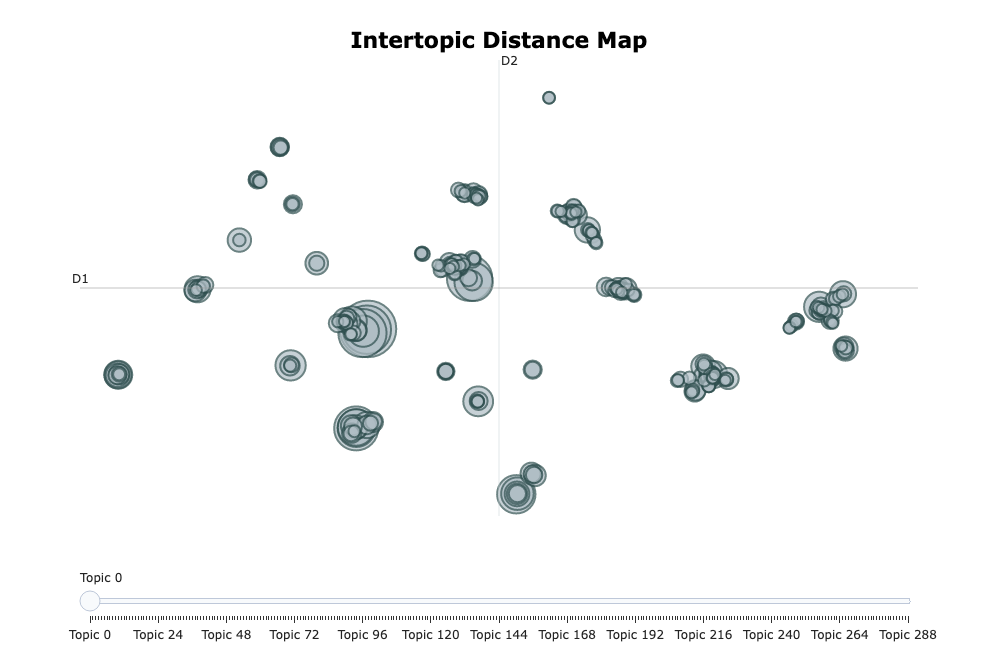

In [73]:
mod_BERT_pos.visualize_topics()

----
Running on full negative sample

In [28]:
%%time
df_filt_neg=df_filt_all[df_filt_all.sent_label==0]
df_filt_neg['cleaned_text_tokens']=df_filt_neg['cleaned_text_tokens'].apply(ast.literal_eval)
df_filt_neg['cleaned_tokens_string'] = df_filt_neg['cleaned_text_tokens'].apply(' '.join)

mod_BERT_neg = BERTopic(calculate_probabilities=True, verbose=True)
topics_neg, probabilities_neg = mod_BERT_neg.fit_transform(df_filt_neg.cleaned_tokens_string.tolist())

Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2023-05-23 14:39:21,910 - BERTopic - Transformed documents to Embeddings
2023-05-23 14:39:28,403 - BERTopic - Reduced dimensionality
2023-05-23 14:39:31,574 - BERTopic - Clustered reduced embeddings


CPU times: user 19min 22s, sys: 3min 38s, total: 23min
Wall time: 2min 35s


In [32]:
mod_BERT_neg.get_topic_info().head(20)

Topic  Count                                    Name
0      -1   1054                     -1_ai_data_new_news
1       0    125  0_clearview_facial_recognition_privacy
2       1    104           1_weather_search_county_hours
3       2    103         2_guardforce_gfai_limited_stock
4       3    100      3_deals_industry_financing_venture
5       4     79           4_bard_google_chatbot_googles
6       5     68          5_link_machine_learning_dollar
7       6     64                 6_edt_apr_lebanon_pixel
8       7     64              7_gebru_google_fired_paper
9       8     61    8_health_medical_healthcare_patients
10      9     59          9_students_chatgpt_teachers_te
11     10     59        10_italy_italian_replika_chatgpt
12     11     59   11_decentralized_machine_learning_dml
13     12     56             12_renalytix_plan_video_etf
14     13     54                   13_ernie_baidu_bot_li
15     14     53         14_matrix_network_traded_dollar
16     15     52         15_ses_corporation_stock_shares
17     16     52         16_lisk_machine_learning_dollar
18     17     49      17_stocks_stock_investorplace_fell
19     18     47         18_renalytix_rnlx_shares_nasdaq

In [47]:
df_filt_neg['Bert_topics']=mod_BERT_neg.topics_
df_filt_neg['Bert_topics_words'] = df_filt_neg['Bert_topics'].apply(lambda x: mod_BERT_neg.get_topic(x))
df_filt_neg.to_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_NEG_BERTopics_Sentiments_NER.csv',index=False)

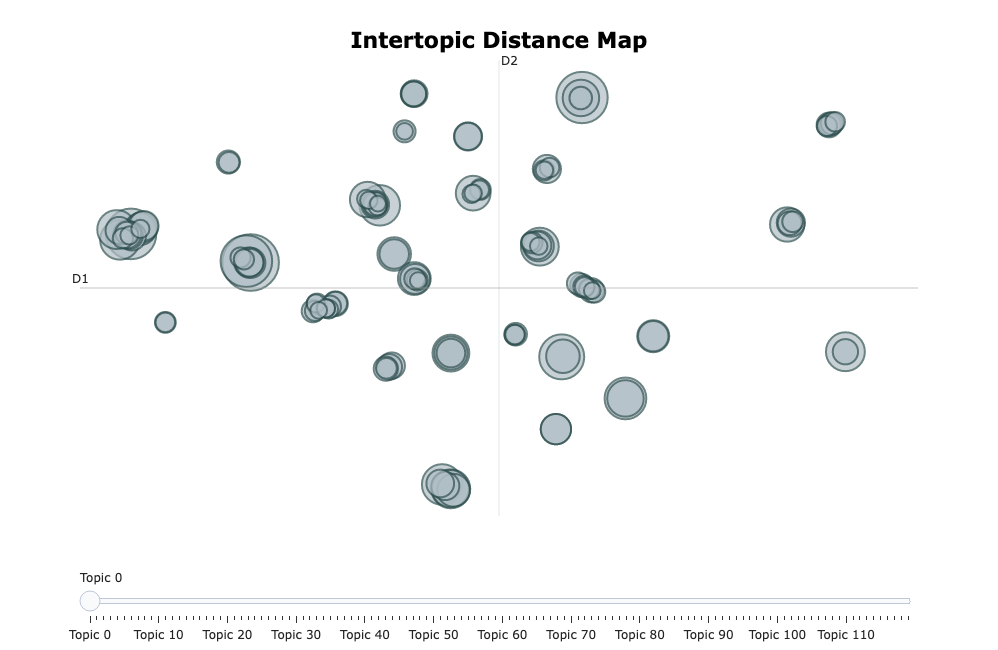

In [72]:
mod_BERT_neg.visualize_topics()

----
Running on full positive sample

In [ ]:
# %%time
# mod_BERT_samp_pos = BERTopic(calculate_probabilities=True, verbose=True)
# topics_post, probabilities_pos = mod_BERT_samp4.fit_transform(df_filt_pos_samp4.cleaned_tokens_string.tolist())

In [71]:
mod_BERT_neg.save('mod_BERT_neg.h5')
mod_BERT_pos.save('mod_BERT_pos.h5')